![logo](./img/LogoLine_horizon_C3S.png)

# Computing the time average of LAI and fAPAR using inverse variance weights

**This notebook can be run on free online platforms, such as Binder, Kaggle and Colab, or they can be accessed from GitHub. The links to run this notebook in these environments are provided here, but please note they are not supported by ECMWF.** 

[![binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/ecmwf-training/c3s-training-submodule-sat-obs-land/main?labpath=lai-fapar-mean-with-inverse-variance-weights.ipynb)
[![kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-training/c3s-training-submodule-sat-obs-land/blob/main/lai-fapar-mean-with-inverse-variance-weights.ipynb)
[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ecmwf-training/c3s-training-submodule-sat-obs-land/blob/main/lai-fapar-mean-with-inverse-variance-weights.ipynb)
[![github](https://img.shields.io/badge/Open%20in-GitHub-black?logo=github)](https://github.com/ecmwf-training/c3s-training-submodule-sat-obs-land/blob/main/lai-fapar-mean-with-inverse-variance-weights.ipynb)

## Introduction

LAI (Leaf Area Index; total one-sided leaf area per unit of horizontal land surface area) and fAPAR (fraction of Absorbed Photosynthetically Active Radiation) are two quantities which are important for the description of the land vegetation and its mass and energy exchange. LAI and fAPAR retrieved with satellite remote sensing is documented in and available through the CDS ([Copernicus Data Store](https://cds.climate.copernicus.eu/datasets/satellite-lai-fapar?tab=overview)). Time series of unsmoothed satellite derived LAI and fAPAR can show noise and natural fluctuations. By computing a monthly average these can be reduced. Each grid cell comes with a retrieval uncertainty which can be used to give appropriate weight to retrievals with different uncertainty in the average computation. Here, we use inverse variance weights, which is the optimal estimator of the average of $N$ uncorrelated measurements in the sense that the estimated average has the least variance among all the weighted averages.

### Inverse Variance Weights


Given a sequence of independent observations $y_i$ with variances $\sigma_{i}^2$, the inverse-variance weighted average is given by
\begin{equation}
\hat{y} = \frac{\sum_i y_i/\sigma_{i}^2}{\sum_i 1/\sigma_{i}^2}.
\end{equation}
The variance of $\hat{y}$ is
\begin{equation}
Var(\hat{y}) = \frac{1}{\sum_i 1/\sigma_{i}^2}.
\end{equation}
Computing $Var(\hat{y})$ first, we can use it to save some operations:
\begin{equation}
\hat{y} = Var(\hat{y}) \sum_i y_i/\sigma_{i}^2
\end{equation}

### Data

The data used in this example are the satellite based LAI and fAPAR product processed with the TIP algorithm (currently v2 -- v4; see e.g. [v2 ATBD](http://dast.data.compute.cci2.ecmwf.int/documents/satellite-lai-fapar/D1.4.3-v2.0_ATBD_CDR-ICDR_LAI_FAPAR_PROBAV_v2.0_PRODUCTS_v1.0.pdf)). Specifically we are using Proba-V-based data with 1 km resolution for May 2019. Data is available on days 10, 20, and 31 of that month. For documentation and other information on LAI and fAPAR data available through the CDS, please visit the [CDS LAI/fAPAR page](https://cds.climate.copernicus.eu/datasets/satellite-lai-fapar?tab=overview).

## Prepare your environment

### Setup the CDSAPI and your credentials

The code below will ensure that the `cdsapi` package is installed. If you have not setup your `~/.cdsapirc` file with your credenials, you can replace `None` with your credentials that can be found on the [how to api](https://cds.climate.copernicus.eu/how-to-api) page (you will need to log in to see your credentials).

In [1]:
!pip install -q cdsapi
# If you have already setup your .cdsapirc file you can leave this as None
cdsapi_key = None
cdsapi_url = None

### Install and import libraries

The following code block will import the python modules required for this notebook. We will be using cdsapi for downloading the data and xarray for handling the data, and matplotlib and cartopy for plotting.

In [ ]:
import os # os provides operating system methods which we use for creating directories adn checking if files exist 

import cdsapi # cdsapi provides programatic access the data available in the Climate Data Store

import xarray as xr             # xarray is a library for working with labelled multi-dimensional arrays
import numpy as np              # numpy is a library for working with arrays of data
from datetime import datetime   # datetime is a library for working with dates and times
import zipfile                  # zipfile is a library for working with zip archives

# The following matplotlib and cartopy libraries are used for plotting the data
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from cartopy import crs as ccrs

### Setup a directory to store the data

In [3]:
DATA_DIR = './data_dir'
os.makedirs(DATA_DIR, exist_ok=True)

## Download and inspect the data

The following code block downloads some data fAPAR and LAI data from the CDS.

There are different ways to download data in the [Climate Data Store](https://cds.climate.copernicus.eu). You can do it manually from the [Download tab](https://cds.climate.copernicus.eu/datasets/satellite-lai-fapar?tab=download) of the catalogue entry, or you can download the data using the CDS-API as we do in this notebook. To write a new request, the easiest way is to select your data parameters on the [Download tab](https://cds.climate.copernicus.eu/datasets/satellite-lai-fapar?tab=download), then click on **"Show API request"**, and copy/paste it in a file (or directly in a notebook cell).

:warning: Please remember to accept the terms and conditions of the dataset, at the bottom of the CDS download form.

In [4]:
download_file = f"{DATA_DIR}/fapar_lai_data.zip"
if os.path.isfile(download_file):
    print("file",download_file,"already exists.")
else:
    c = cdsapi.Client(url=cdsapi_url, key=cdsapi_key)
    c.retrieve(
        'satellite-lai-fapar',
        {
            'variable': [
                'fapar', 'lai',
            ],
            'satellite': ['proba'],
            'sensor': 'vgt',
            'horizontal_resolution': ['1km'],
            'product_version': 'v3',
            'year': ['2019'],
            'month': ['05'],
            'nominal_day': [
                '10', '20', '31',
            ],
        },
        download_file
    )

file ./data_dir/fapar_lai_data.zip already exists.


### Unpack the data

The following cell extracts the data from the zip file and creates separate, sorted, lists of the LAI files and the fAPAR files. We then print out the names and sizes of the LAI files.

In [5]:
# browse through the data folder, and unzip the files existing there.
with zipfile.ZipFile(download_file, 'r') as zip_ref:
    filelist = [os.path.join(DATA_DIR, f) for f in zip_ref.namelist()]
    zip_ref.extractall(DATA_DIR)

# Ensure the filelist is in the correct order:
filelist = sorted(filelist)

# Now we will split our list into LAI and FAPAR files
LAI_files = [f for f in filelist if 'LAI' in f]
FAPAR_files = [f for f in filelist if 'FAPAR' in f]

# Print names and size of the LAI_files in a table, with the size in Gigabytes
print("LAI files:")
print("Filename, Size (GB)")
for f in LAI_files:
    print(f"{os.path.basename(f)}, {os.path.getsize(f) / 1024**3:.3f} GB")

LAI files:
Filename, Size (GB)
c3s_LAI_20190510000000_GLOBE_PROBAV_V3.0.1.nc, 0.505 GB
c3s_LAI_20190520000000_GLOBE_PROBAV_V3.0.1.nc, 0.521 GB
c3s_LAI_20190531000000_GLOBE_PROBAV_V3.0.1.nc, 0.539 GB


Note the size of the files. They are over than 0.5 GB each *in compressed storage* (netCDF internal compression). This demonstrates how effective this compression is, the compression ratio almost reaches a factor of 10. Internally these file use another compression mechanism on top of this by storing most of the data in limited precision to 16-bit unsigned integers. In python they get expanded to 32-bit floats or even 64-bit doubles, which gives another factor of 2 or 4. Thus three dates of LAI with auxiliary variables would take up about 19 GB in memory *if they were processed simultaneously*. And this estimate is not including storage for intermediated results and output. This notebook works around this bottleneck.

### Open the files in xarray

We open the files with `xarray.open_mfdataset` (multi-file dataset), this uses dask to read the data from multiple files and to hold only subsets in memory. This is essential when working with these large datasets as it allows us to work with the data without running out of memory.

As we will see later, this also means that dask does not do the computations on the data immediately. Instead, it builds a "graph" of computations, and then executes them when the result is required, e.g. for producing a plot or writing the oupput to file.

In [6]:
# Open the files using xarray.open_mfdataset, this requires dask to be installed
#  We rechunk the data now to optimize for the operations we will do later
# We put them into a dictionary, so we can access them by their name
ds_dict = {
    'LAI': xr.open_mfdataset(LAI_files).chunk(**{'lat': 3920, 'lon': 10080}),
    'fAPAR': xr.open_mfdataset(FAPAR_files).chunk(**{'lat': 3920, 'lon': 10080}),
}


Choose a variable (fAPAR or LAI) to look at for the remainder of this notebook. We then look at the xarray.Dataset for the chosen variable, here we can explore all the variables and metadata in the file.

In [7]:
varname = 'LAI' # use this for LAI
# varname = 'fAPAR' # use this for fAPAR
uncname = varname + '_ERR' # name of uncertainty layer

ds = ds_dict[varname]
ds

<xarray.Dataset> Size: 30GB
Dimensions:         (time: 3, lat: 15680, lon: 40320)
Coordinates:
  * time            (time) datetime64[ns] 24B 2019-05-10 2019-05-20 2019-05-31
  * lon             (lon) float64 323kB -180.0 -180.0 -180.0 ... 180.0 180.0
  * lat             (lat) float64 125kB 80.0 79.99 79.98 ... -59.98 -59.99
Data variables:
    crs             (time) |S1 3B dask.array<chunksize=(3,), meta=np.ndarray>
    LAI             (time, lat, lon) float32 8GB dask.array<chunksize=(1, 3920, 10080), meta=np.ndarray>
    LAI_ERR         (time, lat, lon) float32 8GB dask.array<chunksize=(1, 3920, 10080), meta=np.ndarray>
    retrieval_flag  (time, lat, lon) float64 15GB dask.array<chunksize=(1, 3920, 10080), meta=np.ndarray>
Attributes: (12/29)
    time_coverage_end:    2019-05-10T23:59:59Z
    time_coverage_start:  2019-04-20T00:00:00Z
    platform:             PROBA-V
    sensor:               VEGETATION
    Conventions:          CF-1.6
    archive_facility:     VITO
    ...                   ...
    comment:              Please refer to Product user Guide for more informa...
    contact:              tip(at)FastOpt.com
    summary:              This file contains the Essential Climate Variable (...
    tiptable_version:     V1.3
    date_created:         2021-03-31
    tracking_id:          1bf423e9-a60e-4249-bbe6-ee72488e4a55

## Compute the inverse variance weighted average and uncertainty

### Applying quality flags

Before calculating the average and uncertainty, we want to use the quality information to mask the data. Both the TIP-LAI and -fAPAR come with a set of informational and quality flags, stored in the layer `retrieval_flag`. We are using the hexadecimal representation `0x1C1` of the bit array `111000001`, here, to avoid cells with the conditions `obs_is_fillvalue`, `tip_untrusted`,`obs_unusable`, and `obs_inconsistent`. The [PUG](https://cds.climate.copernicus.eu/datasets/satellite-lai-fapar?tab=documentation) gives guidance on the selection of these flags.

The cell below creates the mask and applies to both the variable we are looking at the uncertainty. We then print out the xarray.DataArray of variable, the graphical hypercube provides a representation of the dask chunking that xarray is using behind the scenes.

In [8]:
flag_key = 'retrieval_flag'
mask = ds[flag_key].astype('uint32') & 0x1C1 == 0

# Apply the mask to the data and uncertainty layers
ds[varname] = ds[varname].where(mask, np.nan)
ds[uncname] = ds[uncname].where(mask, np.nan)
ds[varname]

<xarray.DataArray 'LAI' (time: 3, lat: 15680, lon: 40320)> Size: 8GB
dask.array<where, shape=(3, 15680, 40320), dtype=float32, chunksize=(1, 3920, 10080), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 24B 2019-05-10 2019-05-20 2019-05-31
  * lon      (lon) float64 323kB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * lat      (lat) float64 125kB 80.0 79.99 79.98 79.97 ... -59.97 -59.98 -59.99
Attributes:
    long_name:      Effective Leaf Area Index 1km
    grid_mapping:   crs
    standard_name:  leaf_area_index
    units:          m2.m-2
    valid_range:    [    0 65534]

### Variance

We can then calculate the variance as a stand-alone variable as we will use it in the both calculations of the average and the uncertainty, as described in the introduction. The cell below, calculates the variance as an `xarray.DataArray`, adds some useful metadata and then adds this to our `xarray.Dataset`. The print out shows our variance `xarray.DataArray` and we can see the attributes we have added.

In [9]:

# Calculate the variance of the inverse variance weighted mean,
variance_ivw = 1. / (1. / ds[uncname]**2).sum(dim='time')

#  set any non-fininte values to np.nan
variance_ivw = variance_ivw.where(np.isfinite(variance_ivw), np.nan)

    # Update the attributes of the dataarray
variance_ivw = variance_ivw.assign_attrs(
    long_name=f'{varname} variance of the inverse variance weighted mean',
    title=f'{varname} ariance of the inverse variance weighted mean',
    units=f"({ds[uncname].units})**2",
)
variance_varname = f'{varname}_IVW_VAR'
variance_ivw = variance_ivw.rename(variance_varname)
ds[variance_varname] = variance_ivw
ds[variance_varname]

<xarray.DataArray 'LAI_IVW_VAR' (lat: 15680, lon: 40320)> Size: 3GB
dask.array<where, shape=(15680, 40320), dtype=float32, chunksize=(3920, 10080), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 323kB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * lat      (lat) float64 125kB 80.0 79.99 79.98 79.97 ... -59.97 -59.98 -59.99
Attributes:
    long_name:  LAI variance of the inverse variance weighted mean
    title:      LAI ariance of the inverse variance weighted mean
    units:      (m2.m-2)**2

### Uncertainty

The uncertainty is simply the square-root of the variance, the cell below calculates the uncertainty, adds some attributes and then adds to our original dataset object.

In [10]:
# Uncertainty is the square root of the variance
uncertainty_ivw = np.sqrt(variance_ivw)
# Update the attributes of the dataarray
uncertainty_ivw = uncertainty_ivw.assign_attrs(
    long_name=f'{varname} uncertainty of the inverse variance weighted mean',
    title=f'{varname} uncertainty of the inverse variance weighted mean',
    units=ds[varname].attrs['units']
)
uncertainty_varname = f'{varname}_IVW_UNC'
uncertainty_ivw = uncertainty_ivw.rename(uncertainty_varname)
ds[uncertainty_varname] = uncertainty_ivw
ds[uncertainty_varname]

<xarray.DataArray 'LAI_IVW_UNC' (lat: 15680, lon: 40320)> Size: 3GB
dask.array<sqrt, shape=(15680, 40320), dtype=float32, chunksize=(3920, 10080), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 323kB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * lat      (lat) float64 125kB 80.0 79.99 79.98 79.97 ... -59.97 -59.98 -59.99
Attributes:
    long_name:  LAI uncertainty of the inverse variance weighted mean
    title:      LAI uncertainty of the inverse variance weighted mean
    units:      m2.m-2

### Inverse variance weighted mean

We finally calculate the average using the inverse theory method. The cell below calculates, adds some attributes and then adds to our original dataset object.

In [11]:
def avgfunc(val, unc, rvarsum):
    # Calculate the inverse variance weighted mean,
    #  set any non-fininte values to np.nan
    average = (val / unc**2).sum(dim="time") * rvarsum
    return average.where(np.isfinite(average), np.nan)

ave_ivw = avgfunc(ds[varname], ds[uncname], variance_ivw)

# Update the attributes of the dataarray
ave_ivw = ave_ivw.assign_attrs(
    long_name=f'{varname} inverse variance weighted mean',
    title=f'{varname} inverse variance weighted mean',
    units=ds[varname].attrs['units']
)
ave_varname = f'{varname}_IVW'
ave_ivw = ave_ivw.rename(ave_varname)
# Add the new dataarray to the dataset
ds[ave_varname] = ave_ivw
ds[ave_varname]

<xarray.DataArray 'LAI_IVW' (lat: 15680, lon: 40320)> Size: 3GB
dask.array<where, shape=(15680, 40320), dtype=float32, chunksize=(3920, 10080), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 323kB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * lat      (lat) float64 125kB 80.0 79.99 79.98 79.97 ... -59.97 -59.98 -59.99
Attributes:
    long_name:  LAI inverse variance weighted mean
    title:      LAI inverse variance weighted mean
    units:      m2.m-2

### Update dataset history

We then update the history of the dataset to document the items we have added. This is good practice, not only if such files are exchanged between colleagues, but also to allow for oneself to trace back and understand the results of one's own work, especially if some time has elapsed since the data was processed.

In [12]:
ds.attrs['history'] += f"| {datetime.now()} - IVW and IVW-uncertainty and IVW-variance added"
ds

<xarray.Dataset> Size: 38GB
Dimensions:         (time: 3, lat: 15680, lon: 40320)
Coordinates:
  * time            (time) datetime64[ns] 24B 2019-05-10 2019-05-20 2019-05-31
  * lon             (lon) float64 323kB -180.0 -180.0 -180.0 ... 180.0 180.0
  * lat             (lat) float64 125kB 80.0 79.99 79.98 ... -59.98 -59.99
Data variables:
    crs             (time) |S1 3B dask.array<chunksize=(3,), meta=np.ndarray>
    LAI             (time, lat, lon) float32 8GB dask.array<chunksize=(1, 3920, 10080), meta=np.ndarray>
    LAI_ERR         (time, lat, lon) float32 8GB dask.array<chunksize=(1, 3920, 10080), meta=np.ndarray>
    retrieval_flag  (time, lat, lon) float64 15GB dask.array<chunksize=(1, 3920, 10080), meta=np.ndarray>
    LAI_IVW_VAR     (lat, lon) float32 3GB dask.array<chunksize=(3920, 10080), meta=np.ndarray>
    LAI_IVW_UNC     (lat, lon) float32 3GB dask.array<chunksize=(3920, 10080), meta=np.ndarray>
    LAI_IVW         (lat, lon) float32 3GB dask.array<chunksize=(3920, 10080), meta=np.ndarray>
Attributes: (12/29)
    time_coverage_end:    2019-05-10T23:59:59Z
    time_coverage_start:  2019-04-20T00:00:00Z
    platform:             PROBA-V
    sensor:               VEGETATION
    Conventions:          CF-1.6
    archive_facility:     VITO
    ...                   ...
    comment:              Please refer to Product user Guide for more informa...
    contact:              tip(at)FastOpt.com
    summary:              This file contains the Essential Climate Variable (...
    tiptable_version:     V1.3
    date_created:         2021-03-31
    tracking_id:          1bf423e9-a60e-4249-bbe6-ee72488e4a55

## Plot the output

The following cell plots the data over Europe. Note that the plot does not show the data at their full resolution, some internal resampling of the `imshow`-method from `pyplot`.

Note that you may see some warnings as the cell below executes, this is because dask is now executing all the computations. Some of these include division by zero, but we have already handled these, and converted them to `np.nan`

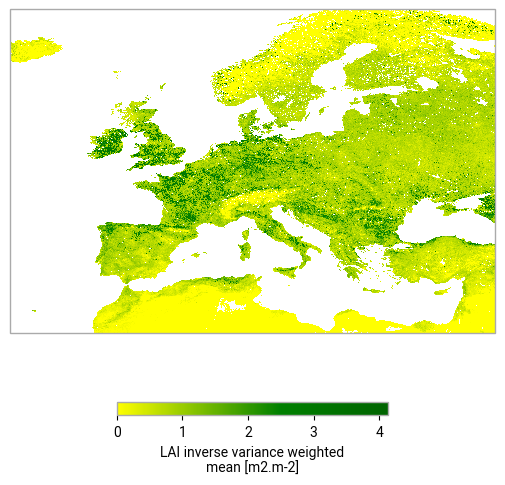

In [17]:
# Define our region of interest
region='Europe'
lat_range = slice(70, 30)
lon_range = slice(-20, 40)

# Extract the data variable
data = ds[ave_varname]
# Extract the data for the region
dataslice = data.sel(dict(lat=lat_range, lon=lon_range))

# define a colour map; green colour should start where LAI reaches 1
mycmap = colors.LinearSegmentedColormap.from_list(
    'lai_cmap',[(0,'yellow'),(0.6,'green'),(1,'darkgreen')]
)
# Set up a figure and axis to plot the data
fig, axis = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.PlateCarree()))
dataslice.plot.imshow(
    ax=axis,
    transform=ccrs.PlateCarree(),  # this is important!
    cbar_kwargs={"orientation": "horizontal", "shrink": 0.5},
    interpolation='none',
    cmap = mycmap
)

We now plot the whole domain, this may take a while to process all the data

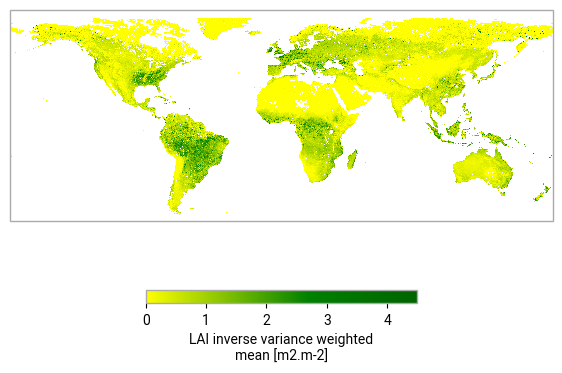

In [14]:
# Now plot the whole domain
fig, axis = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.PlateCarree()))
data.plot.imshow(
    ax=axis,
    transform=ccrs.PlateCarree(),  # this is important!
    cbar_kwargs={"orientation": "horizontal", "shrink": 0.5},
    interpolation='none',
    cmap = mycmap
)

### Write the output to file

Even though dask has not loaded all the data, it is able to predict the size of the resulting object. The cell below prints the full size of the complete dataset, and then a subset of the dataset with just the variables we have calculated here. 

In [15]:
print(ds.nbytes*2**(-30)," GB input")

print(ds[[ave_varname, uncertainty_varname, variance_varname]].nbytes*2**(-30)," GB input")

35.32832863461226  GB input
7.065999507904053  GB input


These anticipated filesizes are very large, and much larger than the ~0.5 Gb that we started with. We can use the `NetCDF` internal compression, `zlib`, to compress the data when we write our output. We also convert the data to intger format with a scale factor and offset which also reduces the file size. As we know that for these variables, negative values are not real, we can se the fill value to -999.

This cell make take a while to execute as xarray is computing the dask graph as it writes the output to file.

In [16]:
outfile = f"{DATA_DIR}/{varname}-inverse-variance-mean.nc"
if os.path.isfile(outfile):
    print("file",outfile,"already exists. Processing skipped.")
else:
    variable_encoding = {
        "dtype": np.int16,  # Store as int16
        "scale_factor": 1e-3,
        "add_offset": 0,
        "_FillValue": -999,  # Missing value
        "zlib": True,
    }
    output_encoding = {
        ave_varname:variable_encoding,
        uncertainty_varname:variable_encoding,
        variance_varname:variable_encoding
    }
    ds[[ave_varname, uncertainty_varname, variance_varname]].to_netcdf(
        outfile,mode='w', encoding=output_encoding
    )

# Print the size of the output file
print(f"{os.path.basename(outfile)}, {os.path.getsize(outfile) / 1024**3:.3f} GB")

file ./data_dir/LAI-inverse-variance-mean.nc already exists. Processing skipped.
LAI-inverse-variance-mean.nc, 0.521 GB


## Key messages

- Uncertainties provided with the data help to improve the quality of the time average.
- Depending on the statistical model, inverse variance weights may be a good choice for your application
- Often, quality flags exist which mark data that may be unreliable and should be ommited for general purposes.
- Global datasets can be huge, it is worth thinking about parallel processing, e.g. using `dask`.
- It is good practice to maintain units and other metainfo, even in intermediate files.